In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix


import xgboost as xgb
import seaborn as sns

%matplotlib inline


### Load Data

In [56]:
df = pd.read_csv('train.csv')
orig_df = pd.read_csv('train.csv')

In [57]:
df.shape

(26729, 10)

In [58]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [59]:
df.columns

Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed',
       u'Color'],
      dtype='object')

### Convert age column to age in years
The age column contains strings and the unit of age is not consistent. So, we will convert the age column into age in years. There are some entries with no age value. We will first fill in those null values with -99, and then replace them with the average age.

In [60]:
df['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [61]:
Ages = df['AgeuponOutcome'].astype(str)
y = [float(age.split()[0]) if 'year' in age
     else float(age.split()[0])/52. if 'week' in age
     else float(age.split()[0])/12. if 'month' in age
     else float(age.split()[0])/352. if 'week' in age
     else -99.0
     for age in Ages]

In [62]:
y[y == -99] = np.mean(y[y != -99])

#### Here, we replace the missing ages with the average age of the animals

In [63]:
df['AgeuponOutcome'] = pd.DataFrame({'AgeuponOutcome': y})

In [64]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1.000000,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1.000000,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2.000000,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,0.057692,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2.000000,Lhasa Apso/Miniature Poodle,Tan


## Basic Stats for Dogs vs Cats

#### Average age upon Outcome

In [65]:
df[df['AnimalType'] == 'Dog']['AgeuponOutcome'].mean()

2.2319505758749227

In [66]:
df[df['AnimalType'] == 'Cat']['AgeuponOutcome'].mean()

-1.6021397843519833

#### Number of dogs vs cats

In [67]:
len(df[df['AnimalType'] == 'Dog'])

15595

In [68]:
len(df[df['AnimalType'] == 'Cat'])

11134

Summary on basic stats: The average age for a dog (2.75 yrs) is greater than the average age of cats (1.36 yrs) upon the outcome. The shelter also has sheltered more dogs than cats over the course of 3 years.

## Create columns for male vs female, fixed vs intact


In [69]:
df['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [70]:
df['SexuponOutcome'] = df['SexuponOutcome'].replace(np.nan,'Unknown')

In [71]:
sex = ['male' if 'Male' in df['SexuponOutcome'].iloc[i] 
       else 'female' if 'Female' in df['SexuponOutcome'].iloc[i] 
       else 'unknown'
       for i in range(len(df['SexuponOutcome']))]

spayed_neutered = ['fixed' if any(x in df['SexuponOutcome'].iloc[i] for x in ['Neutered','Spayed'])
                    else 'not_fixed' if 'Intact' in df['SexuponOutcome'].iloc[i]
                    else 'unknown_fixed'
                    for i in range(len(df['SexuponOutcome']))]

In [72]:
set(spayed_neutered)

{'fixed', 'not_fixed', 'unknown_fixed'}

In [73]:
set(sex)

{'female', 'male', 'unknown'}

In [74]:
df['Fixed'] = pd.DataFrame({'fixed':spayed_neutered})
df['Sex'] = pd.DataFrame({'Sex': sex})
df = df.drop('SexuponOutcome',axis = 1)

## Simplify the Breed Feature

In [75]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Sex
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog Mix,Brown/White,fixed,male
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,fixed,female
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull Mix,Blue/White,fixed,male
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,not_fixed,male
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso/Miniature Poodle,Tan,fixed,male


In [76]:
len(df['Breed'].unique())

1380

###### Currently, there are 1380 different breed classifications among cats and dogs

In [77]:
df['Breed'].value_counts()[0:10]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64

In [78]:
df[df['AnimalType'] == 'Cat']['Breed'].value_counts()[0:10]

Domestic Shorthair Mix      8810
Domestic Medium Hair Mix     839
Domestic Longhair Mix        520
Siamese Mix                  389
Domestic Shorthair           143
Snowshoe Mix                  75
Maine Coon Mix                44
Manx Mix                      44
Domestic Medium Hair          42
Russian Blue Mix              33
Name: Breed, dtype: int64

In [79]:
len(df[df['AnimalType'] == 'Cat']['Breed'].unique())

60

In [80]:
len(df[df['AnimalType'] == 'Dog']['Breed'].unique())

1320

#### Domestic Shorthair Mix seems to be a classification for cats only

- Cat breeds seem to be somewhat limited with 60 different breeds while dogs have 1320 different classifications. We will only simplify dog breeds.

In [81]:
df[df['AnimalType'] == 'Dog']['Breed'].value_counts()[0:20]

Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
German Shepherd Mix           575
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Jack Russell Terrier Mix      146
Yorkshire Terrier Mix         143
Chihuahua Longhair Mix        142
Siberian Husky Mix            138
Miniature Schnauzer Mix       136
Beagle Mix                    124
Rottweiler Mix                113
American Bulldog Mix          109
Name: Breed, dtype: int64

###### Let's remove the "Mix" from the dog breeds and also take only the first breed from classifications in the form "breed 1 / breed 2", assuming that the first breed listed is the dominant breed

In [82]:
import re
breeds = list(df[df['AnimalType'] == 'Dog']['Breed'])
dog_breeds = [re.sub(' Mix', '', dog) if 'Mix' in dog else dog.split("/")[0] for dog in breeds]
# for i in range(len(dog_breeds)):
#     if ('Mix' in dog_breeds[i]):
#         dog_breeds[i] = re.sub(' Mix', '', dog_breeds[i])
#     else:
#         dog_breeds[i] = dog_breeds[i].split("/")[0]
    
            

In [83]:
len(set(dog_breeds))

188

In [84]:
dog_breeds_df = pd.DataFrame({'Breed':dog_breeds})

###### We were able to narrow down the different classes of dog breeds from 1320 to 188

In [85]:
dog_breeds_df['Breed'].value_counts()[0:10]

Chihuahua Shorthair      2145
Pit Bull                 2113
Labrador Retriever       1915
German Shepherd           826
Australian Cattle Dog     511
Dachshund                 510
Boxer                     360
Border Collie             334
Miniature Poodle          310
Australian Shepherd       229
Name: Breed, dtype: int64

###### Now let's replace all the dog breed classifications from the original dataframe with the new breed classifications

In [86]:
df.ix[df.AnimalType == 'Dog', 'Breed'] = dog_breeds

In [87]:
len(df['Breed'].unique())

248

In [88]:
x = df['Breed'].value_counts().index.tolist()
y = df['Breed'].value_counts().tolist()

In [89]:
common_breed = df['Breed'].value_counts().index.tolist()[0:10]
pd.crosstab(df[df['Breed'].isin(common_breed)]['Breed'],df['OutcomeType'])

OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Breed,,,,,
Australian Cattle Dog,243,1,20,126,121
Chihuahua Shorthair,966,13,90,478,598
Dachshund,243,0,15,95,157
Domestic Longhair Mix,199,12,56,48,205
Domestic Medium Hair Mix,357,11,62,26,383
Domestic Shorthair Mix,3273,112,535,352,4538
German Shepherd,372,3,37,237,177
Labrador Retriever,857,4,82,498,474
Pit Bull,625,8,287,678,515


## Simplify Dog Color Column

#### The color column has 366 different colors. We will simplify this column similar to the breed column, taking the first color as the dominant color.

In [90]:
len(df['Color'].unique())

366

In [91]:
len(df[df['AnimalType'] == 'Dog']['Color'].unique())

262

In [92]:
df[df['AnimalType'] == 'Dog']['Color'].value_counts()[0:15]

Black/White            1730
Brown/White             882
Black                   851
White                   806
Tan/White               773
Tricolor                751
Black/Tan               672
Brown                   637
Tan                     627
White/Brown             562
White/Black             475
Brown Brindle/White     450
Black/Brown             435
Blue/White              414
White/Tan               389
Name: Color, dtype: int64

In [93]:
df[df['AnimalType'] == 'Cat']['Color'].value_counts()[0:15]

Brown Tabby           1635
Black                 1441
Black/White           1094
Brown Tabby/White      940
Orange Tabby           841
Tortie                 530
Calico                 517
Orange Tabby/White     455
Blue Tabby             433
Blue                   385
Torbie                 335
Blue/White             288
Blue Tabby/White       241
Cream Tabby            198
White/Black            168
Name: Color, dtype: int64

In [94]:
# Take the first color
colors = df['Color']
color = [c.split("/")[0] for c in df['Color']]

In [95]:
len(pd.DataFrame({'Color':color})['Color'].unique())

57

In [96]:
pd.DataFrame({'Color':color})['Color'].value_counts()[0:15]

Black            6422
White            3344
Brown Tabby      2592
Brown            1951
Tan              1674
Orange Tabby     1299
Blue             1199
Tricolor          800
Red               779
Brown Brindle     699
Blue Tabby        678
Tortie            580
Calico            552
Chocolate         448
Torbie            398
Name: Color, dtype: int64

** Taking the first listed color as the dominant color, we reduced the number of possibilites for color definition from 366 to 57 **

In [97]:
df['Color'] = color

In [98]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Sex
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog,Brown,fixed,male
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,fixed,female
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull,Blue,fixed,male
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,not_fixed,male
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso,Tan,fixed,male


## Simplify the date and time column


In [99]:
df['DateTime'].head()

0    2014-02-12 18:22:00
1    2013-10-13 12:44:00
2    2015-01-31 12:28:00
3    2014-07-11 19:09:00
4    2013-11-15 12:52:00
Name: DateTime, dtype: object

In [100]:
from datetime import datetime
d = df['DateTime'][0].split()[0]
dates = [df['DateTime'][i].split()[0] for i in range(len(df['DateTime']))]
date = [datetime.strptime(d,'%Y-%m-%d') for d in dates]


In [101]:
date[0].day

12

In [102]:
season = ['Winter' if d.month % 11 <= 2
         else 'Spring' if (d.month % 11 >= 3) & (d.month % 11 <= 5)
         else 'Summer' if (d.month % 11 >= 6) & (d.month % 11 <= 8)
         else 'Fall'
         for d in date]

In [103]:
week = [1 if d.day <= 7
       else 2 if (d.day > 7) & (d.day <= 14)
       else 3 if (d.day > 14) & (d.day <= 21)
       else 4
       for d in date]

In [104]:
df['Season'] = season
df['Week'] = week

In [105]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Sex,Season,Week
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog,Brown,fixed,male,Winter,2
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,fixed,female,Fall,2
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull,Blue,fixed,male,Winter,4
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,not_fixed,male,Summer,2
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso,Tan,fixed,male,Winter,3


### Create Indicator Column whether the animal was given a name or not

In [106]:
df['Name'] = df['Name'].isnull() * 1.
df = df.rename(columns = {'Name':'NoName'})

### Create column for indicator of Animal Type

In [107]:
df['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [108]:
df['AnimalType'] = (df['AnimalType'] == 'Dog') * 1.


### Create Dummy Variables for Columns with Categorical Variables

In [109]:
categorical_var = ['Color', 'Breed', 'Season','Fixed', 'Sex']

dat = pd.concat([df.drop(categorical_var, axis = 1), pd.get_dummies(df[categorical_var])], axis = 1)

### Check dimensions of data frame to check dummy function

### Create Labels

In [110]:
lab = dat['OutcomeType']

In [111]:
lab.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [112]:
le = LabelEncoder()
labels = le.fit_transform(dat['OutcomeType'])


### Drop columns not needed for models

In [113]:
dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype'],axis = 1).dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

In [114]:
dat = dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype', 'AnimalType'],axis = 1)

### Create Training and Testing Sets

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(dat, labels, test_size = 0.25)

In [116]:
df.OutcomeType.value_counts()/float(df.shape[0])

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: OutcomeType, dtype: float64

 We now need to normalize the training and testing set.

In [117]:
X_train = normalize(X_train, axis = 1)
X_test = normalize(X_test, axis = 1)

### Logistic Regression Grid Search and Cross Validation

In [118]:
log_model = LogisticRegression(penalty = 'l1')
params = {'C':[0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]}
gs_model = GridSearchCV(log_model, params)
gs_model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [119]:
gs_model.best_params_

{'C': 2}

In [120]:
C_val = gs_model.best_params_['C']

best_log_model = LogisticRegression(C = C_val, penalty = 'l1')
best_log_model.fit(X_train, Y_train)
best_log_model.score(X_test, Y_test)

0.63669010923238067

In [121]:
log_loss(Y_test, best_log_model.predict_proba(X_test))

0.9097264225846845

[[2294    0    0  315   97]
 [   4    0    0    2   45]
 [  60    0    5   91  210]
 [ 575    0    0  520  110]
 [ 714    0    3  202 1436]]


array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

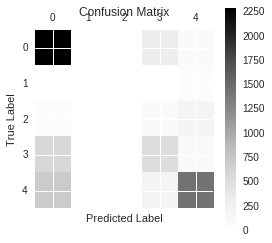

In [122]:
cm = confusion_matrix(Y_test, best_log_model.predict(X_test))

plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

print cm

le.classes_

### Gradient Boosting

### Grid Search for Gradient Boosting

In [123]:
# params = {'n_estimators': [200, 300, 450], 'learning_rate':[0.1, 0.5],
#           'max_depth':[5, 6, 7, 8], 'max_features':['sqrt', .40], 'min_samples_split':[2, 20, 30, 50, 100]}
params = {'n_estimators':[200, 300], 'max_features':['sqrt', 40], 'max_depth':[5, 7]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), params, verbose = 1)
grid_search_gb.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 18.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300], 'max_features': ['sqrt', 40], 'max_depth': [5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [124]:
grid_search_gb.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

In [125]:
num_estimators = grid_search_gb.best_params_['n_estimators']
depth = grid_search_gb.best_params_['max_depth']
features = grid_search_gb.best_params_['max_features']

In [126]:
best_gb_model = GradientBoostingClassifier(n_estimators = num_estimators, learning_rate = 0.1, max_depth = depth)
best_gb_model.fit(X_train, Y_train)
best_gb_model.score(X_test, Y_test)

0.63818644321412543

In [127]:
log_loss(Y_test, best_gb_model.predict_proba(X_test))

0.86743671702706471

[[2178    1    6  304  217]
 [   4    1    5    1   40]
 [  48    2   44   88  184]
 [ 515    1   18  553  118]
 [ 607    9   40  210 1489]]


array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

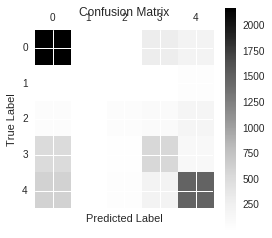

In [128]:
cm = confusion_matrix(Y_test, best_gb_model.predict(X_test))

plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

print cm

le.classes_

In [129]:
feat_imp = pd.DataFrame({'features':dat.columns.values,'values':best_gb_model.feature_importances_})

In [130]:
top_feat = feat_imp.sort('values').iloc[-10:]
top_feat

/home/truong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,features,values
316,Sex_male,0.023074
315,Sex_female,0.024309
313,Fixed_not_fixed,0.024355
309,Season_Spring,0.026333
310,Season_Summer,0.028309
0,NoName,0.029660
311,Season_Winter,0.030667
2,Week,0.051106
312,Fixed_fixed,0.066684
1,AgeuponOutcome,0.100743


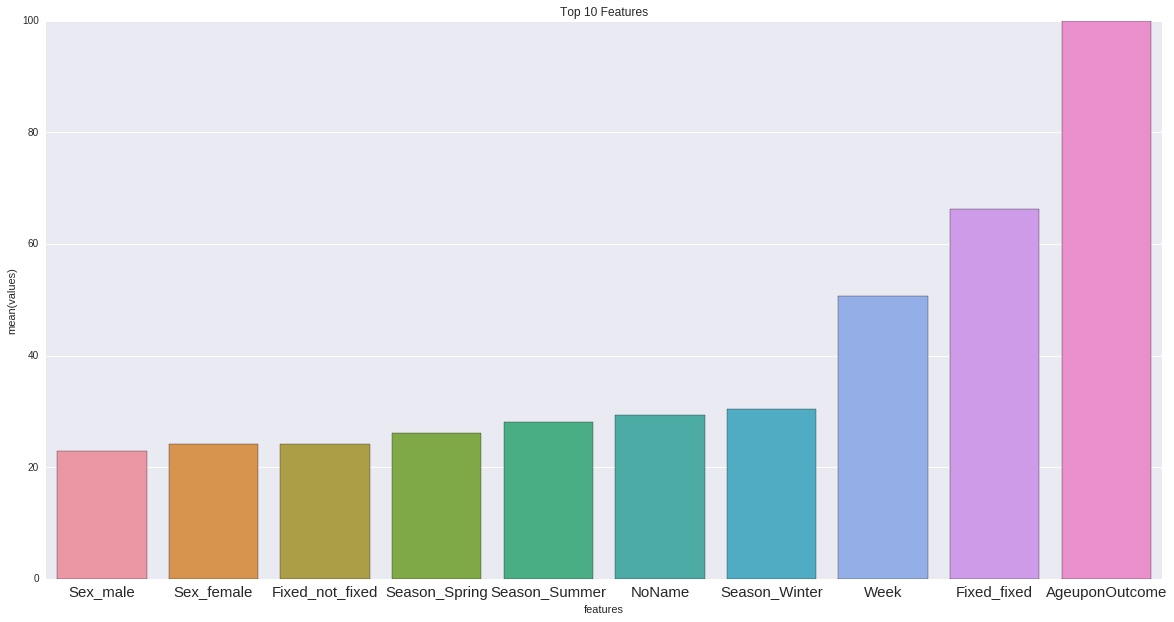

In [131]:
plt.figure(figsize = (20,10))
plt.title('Top 10 Features')
plt.xticks(fontsize = 15)
sns.barplot(top_feat['features'], 100.0 * top_feat['values']/np.max(best_gb_model.feature_importances_))

### XgBoost

In [132]:
params = {'n_estimators':[200, 300], 'max_depth':[4, 5, 6], 'subsample':[1, 0.8]}
gs_xgb = GridSearchCV(xgb.XGBClassifier(), params, verbose = 1)
gs_xgb.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 15.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300], 'subsample': [1, 0.8], 'max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [133]:
gs_xgb.best_params_

{'max_depth': 4, 'n_estimators': 200, 'subsample': 1}

In [134]:
depth = gs_xgb.best_params_['max_depth']
estimators = gs_xgb.best_params_['n_estimators']
sub_sample = gs_xgb.best_params_['subsample']

In [141]:
xgb_model = xgb.XGBClassifier(n_estimators = estimators, max_depth = depth, subsample = sub_sample,
                             objective = 'multi:softmax')
xgb_model.fit(X_train, Y_train, eval_metric = 'mlogloss', eval_set = [(X_test, Y_test)],
              early_stopping_rounds = 100,verbose = False)
xgb_model.score(X_test, Y_test)

0.64656591351189585

In [142]:
log_loss(Y_test, xgb_model.predict_proba(X_test))

0.84486234618483813

### Majority Vote

In [137]:
mv_model = VotingClassifier([('xgb',xgb_model), ('gb',best_gb_model), ('log',best_log_model)], voting = 'soft')
mv_model.fit(X_train, Y_train)
mv_model.score(X_test, Y_test)

0.64940894807721083

In [138]:
log_loss(Y_test, mv_model.predict_proba(X_test))

0.85329155785166888

### ZeroR Baseline

In [144]:
lab.value_counts()[0]/float(len(labels))

0.40289573122825395

** Using the zero rule baseline, we would get a 40% accuracy by "guessing" all animals will be adopted. Using numerous models, the best result is 65% prediction accuracy, a 24% increase, using the Majority Vote with soft voting ensemble. **